In [1]:
import lb_scrapper as lbs
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re
import numpy as np
from modellingtools import kpis,graphics

# How to use the scrapper

## The scrapper object
The scrapper is a simple class with a few built-in methods. A lot of arguments are optionnal. For complete documentation see the code.

In [2]:
mscrapper = lbs.request_lb(request="", dataname="Lyon_rent")
mscrapper.check_nb_entries()

Currently, 2609 entries.


There are methods and attributes associated with this scrapper object :

In [3]:
[x for x in dir(mscrapper) if not x.startswith('__')]

['check_nb_entries',
 'dataloc',
 'dataname',
 'del_prev_db',
 'delete_data',
 'request',
 'update_db']

The methods are :
- `check_nb_entries`: check the number of line in the current database
- `del_prev_db`:  delete previous database
- `update_db`: update the current database

The attributes are :
- `delete_data`: Are the data deleted at init of the object
- `dataname`: name of the database
- `dataloc`: location of the database
- `request`: text requested on LBC

As the results are stored in a SQL database, we can convert it to a dataframe to explore it.

In [4]:
conn = sqlite3.connect('./datas/scrapped_lbc.db')
df = pd.read_sql_query("select * from Lyon_rent;", conn)
df.columns.tolist()
# I don't need lines with NA
df = df.dropna(axis=0)

The columns are the following :
- link: link to the post
- title: title of the post
- price: rent in euro
- city: postcode, gives the area in Lyon
- nb_rooms: number of rooms (living room, bedrooms)
- surface: size in square meter
- charges: are the charges included or not in the price
- furnished: are the furniture included
- description: content of the post (in french)
- update_date: date of collect

## Working with datas

As the datas are raw, we need to clean them a bit and change some things.

### Quick work on the features

First, let's convert the city as an ordered factor, as it is easier to understand.

In [5]:
df.city=pd.Categorical(df.city, categories=sorted(df.city.unique().tolist()),ordered=True)

Now let us add two dummy factors, to check if there is a parking slot, or a balcony included.

In [6]:
df['TOP_parking']=df.description.str.contains(re.compile("parking|garage",re.IGNORECASE))

In [7]:
df['TOP_balcon']=df.description.str.contains(re.compile("terrasse|balcon",re.IGNORECASE))

Furnished and charges can also be translated to a boolean

In [8]:
df.loc[df.furnished == 'Meublé',"furnished"] = 1
df.loc[df.furnished != 1,"furnished"] = 0

df.loc[df.charges == 'Oui',"charges"] = 1
df.loc[df.charges != 1,"charges"] = 0

The bascic stastistics for numerical variables are the following :

In [9]:
df.select_dtypes(include=[np.number,bool]).astype(float).describe()

,price,nb_rooms,surface,charges,furnished,TOP_parking,TOP_balcon
count,2561.000000,2561.000000,2561.000000,2561.000000,2561.000000,2561.000000,2561.000000
mean,846.401796,2.571261,53.798126,0.981648,0.327997,0.289340,0.263569
std,242.944812,0.698560,21.473118,0.134248,0.469575,0.453545,0.440654
min,500.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,660.000000,2.000000,40.000000,1.000000,0.000000,0.000000,0.000000
50%,800.000000,2.000000,52.000000,1.000000,0.000000,0.000000,0.000000
75%,959.000000,3.000000,67.000000,1.000000,1.000000,1.000000,1.000000
max,1700.000000,5.000000,160.000000,1.000000,1.000000,1.000000,1.000000


In this request, the prices goes from 500 to 1700, with a mean of 850, which is slightly higher than the median. The Q1-Q3 interval is approx. 650 to 950, which means that a lot of prices are in that range.

The number of rooms have been fixed to be between 2 and 5, but actually most of the offers are for 3 rooms as we can see.

A lot of surfaces values are equal to 1, which is a mistake or a mislead, so we can delete it.

In [10]:
df = df[df.surface != 1]

In [11]:
df.select_dtypes(include=[np.number,bool]).astype(float).describe()

,price,nb_rooms,surface,charges,furnished,TOP_parking,TOP_balcon
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,847.231268,2.568246,55.765492,0.980964,0.338194,0.290806,0.266100
std,243.365253,0.701859,19.248263,0.136679,0.473191,0.454226,0.442007
min,500.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,661.000000,2.000000,41.000000,1.000000,0.000000,0.000000,0.000000
50%,800.000000,2.000000,53.000000,1.000000,0.000000,0.000000,0.000000
75%,960.000000,3.000000,68.000000,1.000000,1.000000,1.000000,1.000000
max,1700.000000,5.000000,160.000000,1.000000,1.000000,1.000000,1.000000


The surface goes from 12 to 160, with most of the offers between 41 and 68.

A third of the available flat are furnished, which might have an impact on the price : as furniture are provided the owner make a higher investment and has more responsability.

Finally, the parking and balcony are not as seldom as in paris, since more than a quarter of the sample have one.

### What does it looks like ?

Let's explore a bit further the variable, to see what we have

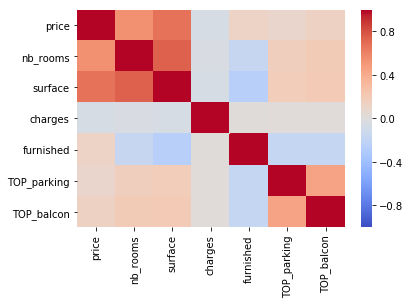

,price,nb_rooms,surface,charges,furnished,TOP_parking,TOP_balcon
price,1.000000,0.544902,0.673218,-0.047618,0.131332,0.100689,0.140301
nb_rooms,0.544902,1.000000,0.742586,-0.035025,-0.159196,0.170308,0.200698
surface,0.673218,0.742586,1.000000,-0.053908,-0.250645,0.186227,0.209887
charges,-0.047618,-0.035025,-0.053908,1.000000,0.018138,0.030465,0.023519
furnished,0.131332,-0.159196,-0.250645,0.018138,1.000000,-0.171215,-0.170854
TOP_parking,0.100689,0.170308,0.186227,0.030465,-0.171215,1.000000,0.449928
TOP_balcon,0.140301,0.200698,0.209887,0.023519,-0.170854,0.449928,1.000000


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df2=df.drop(["link","title","description","update_date"],axis=1).copy().dropna()
for x in df2.columns:
    if df2[x].dtypes=='object':
        df2[x]=le.fit_transform(df2[x])

corr = df2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="coolwarm",
           vmin = -1, vmax =1)
plt.show()
display(corr)
del df2

The correlation matrix is interesting. It shows us that the greatest positive correlation are Price/Surface and Parking/Balcony. The first one is not so surprising, but the value (approx. 1/2) shows that the link is not totally linear between the two variables.

For the second one, we can conclude that when you have a parking, you are likely to have a balcony. 

We also have a good correlation between surface and number of rooms, which is expected.

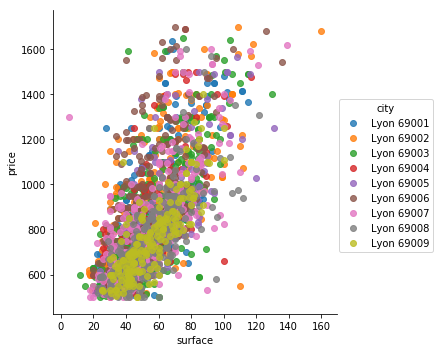

In [13]:
sns.lmplot(y="price",x='surface', hue="city",data=df,fit_reg=False)
plt.show()

We saw that the correlation is positive between price and surface. By coloring the point by area we see that some area tends to be more expensive than other, but without separating the graphs it is hard to see.
Also the number of room can be important, so separating the plots according to these factors seems to be reasonable.

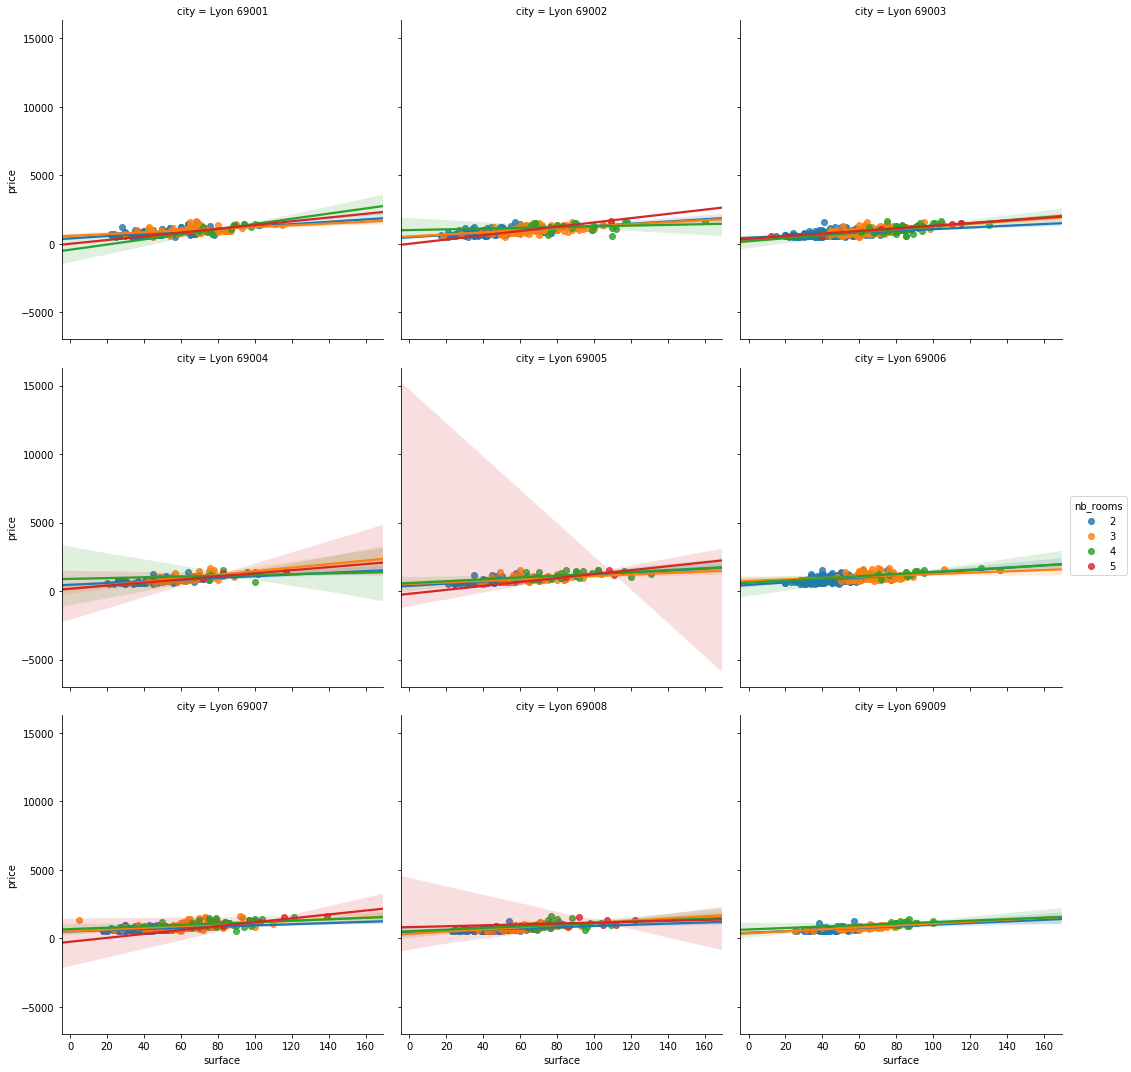

In [14]:
sns.lmplot(y="price",x='surface', hue="nb_rooms", col="city",data=df,col_wrap=3)
plt.show()

If we excluse the 5 rooms, most of the regressions seems to be aligned, which might indicate that this is not as relevant as we might think in the first place. Nevertheless, for some areas the levels seems to be different : for instance in the 69004 area.

Between districts, the range of prices are different. It is interesting to see that contrary to the complete scatterplot, here the relationship between price and surface seems to be clearer, with less volatility.

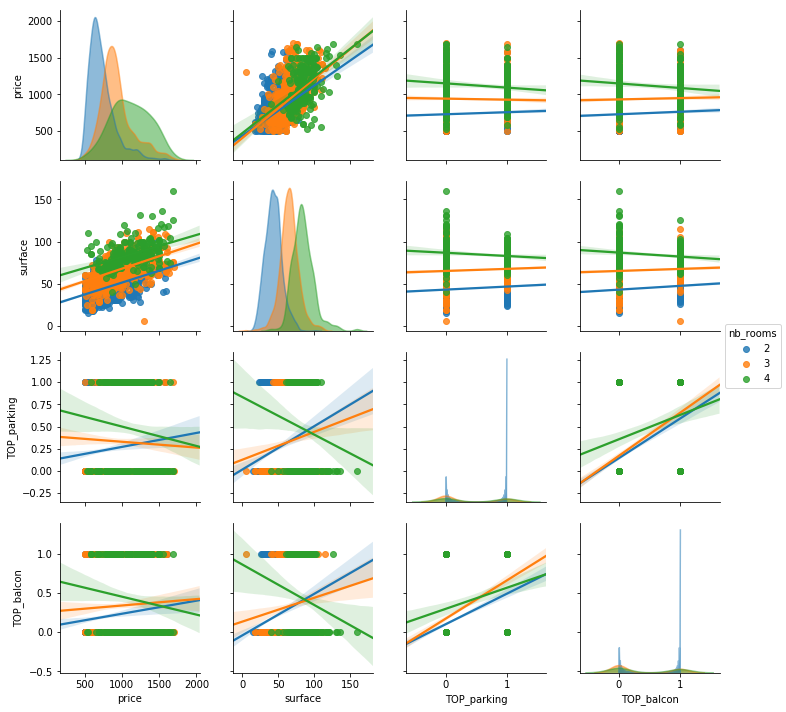

In [15]:
sns.pairplot(df[df.nb_rooms != 5].dropna(), kind="reg",hue="nb_rooms",diag_kind="kde",diag_kws=dict(shade=True, alpha = 0.5),
            vars=['price','surface','TOP_parking','TOP_balcon'])
plt.show()

# Is it possible to build a model for the price ?

With just the information we have, we can try to build a model to predict the price of the rent depending on the variable we have. For instance let's try to build a simple GBM to have a baseline

In [16]:
from sklearn.model_selection import train_test_split
var_int = ['city','nb_rooms','surface','charges','furnished','TOP_parking','TOP_balcon']
X=df[var_int + ['price']].dropna()

X_train, X_test, y_train, y_test = train_test_split(pd.get_dummies(X[var_int]), 
                                                    X['price'], 
                                                    random_state=0)

X_test_ = X_test.copy()

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state = 0,n_estimators=100,learning_rate=0.05)
gbm.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

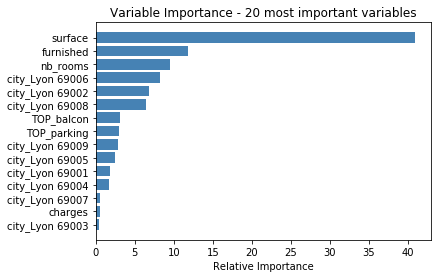

In [18]:
graphics.plot_factor_imp(gbm,20,X_test.columns)

Without a surprise, the surface is the most important variable when it comes to predict the price of the flat. It seems that some district have some importance too, like the second, sixth and eight, and also the number of rooms with a very small importance.

In [19]:
from sklearn import metrics
pred_test = gbm.predict(X_test)
df_KPI = pd.DataFrame(index=["RMSE","MAE","Gini"])

df_KPI['GBM_base']=[np.sqrt(metrics.mean_squared_error(y_test,pred_test)),
                    metrics.mean_absolute_error(y_test,pred_test),
                    kpis.Gini(y_test,pred_test)
                   ]

In [20]:
df_KPI

,GBM_base
RMSE,154.090662
MAE,108.727996
Gini,0.801192


These KPIs are going to be the base of our models.

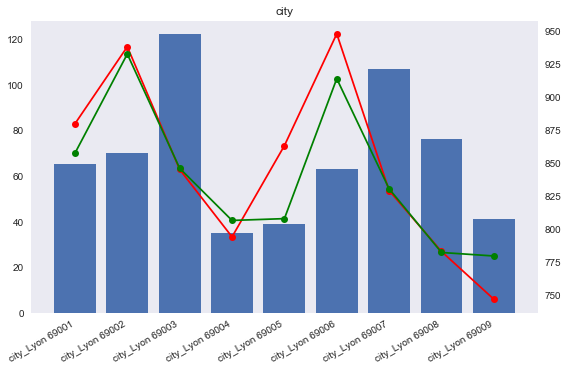

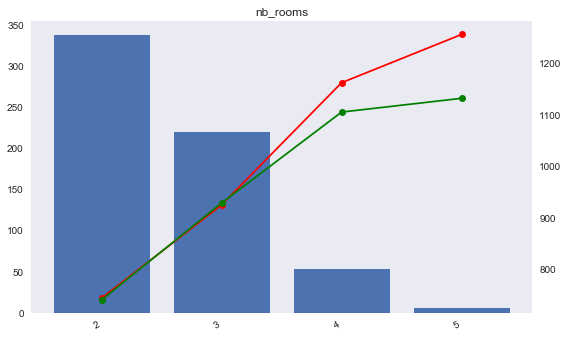

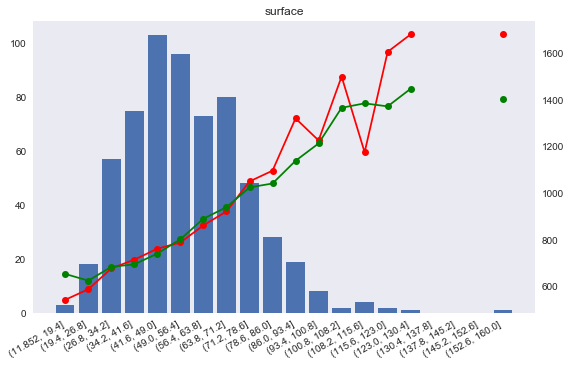

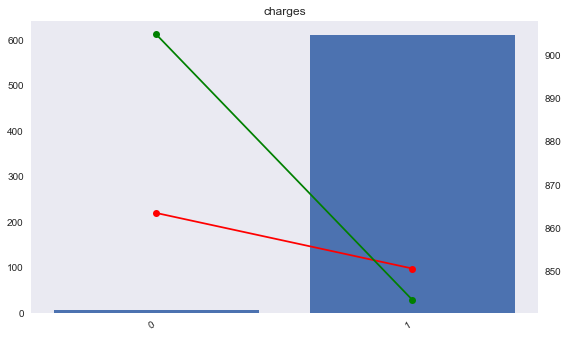

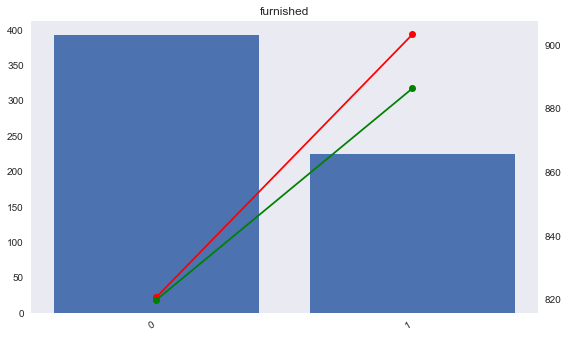

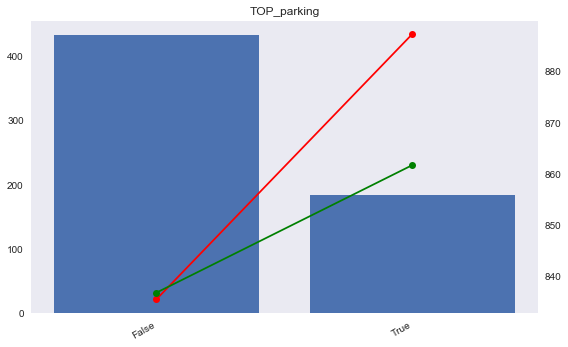

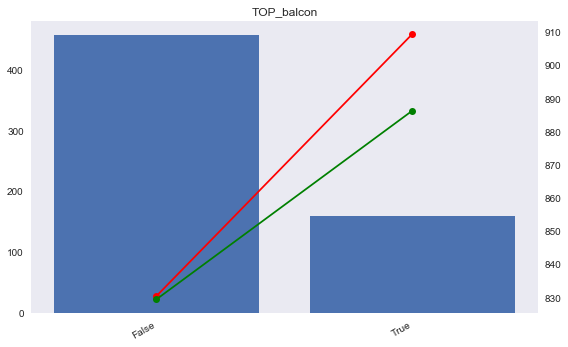

In [21]:
X_test_['city']=X_test[[x for x in X_test.columns.tolist() if x.startswith("city")]].idxmax(axis=1)
plt.style.use('seaborn')
for i, var in enumerate(var_int):
    graphics.plot_means_match(X_test_,var,y_test,pred_test)


The match between observed/fitted is not perfect, but seems to be good in average.

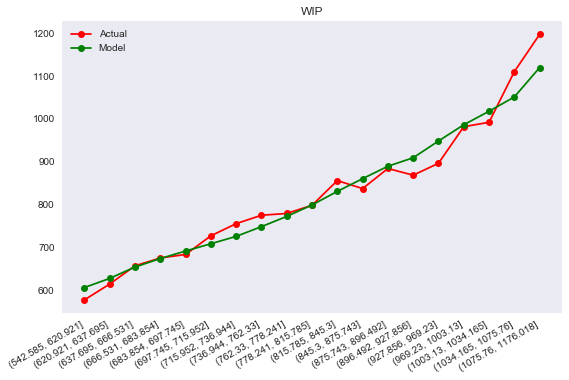

In [22]:
graphics.lift_curve(y_test,pred_test)

The model is far from perfect, there are bumps in the middle, and we really under estimate the higher prices.
We saw the relationship between seems to be linear, so we can try a regular linear model.

In [23]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
reg = linear_model.LassoCV(cv=20,alphas=np.logspace(-2,0,5))
pipe = Pipeline(steps=[('scaling', mmscaler), ('lassoreg', reg)])
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('lassoreg', LassoCV(alphas=array([ 0.01   ,  0.03162,  0.1    ,  0.31623,  1.     ]),
    copy_X=True, cv=20, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

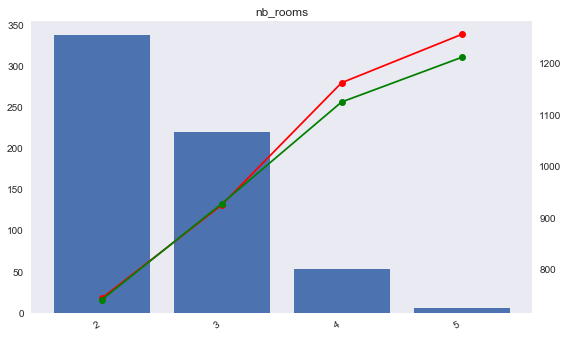

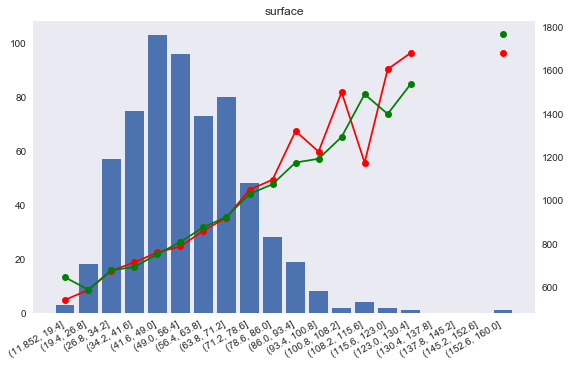

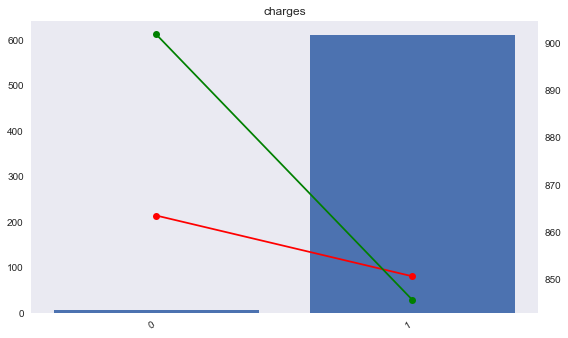

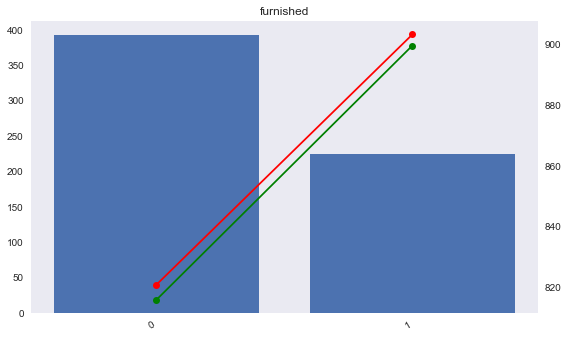

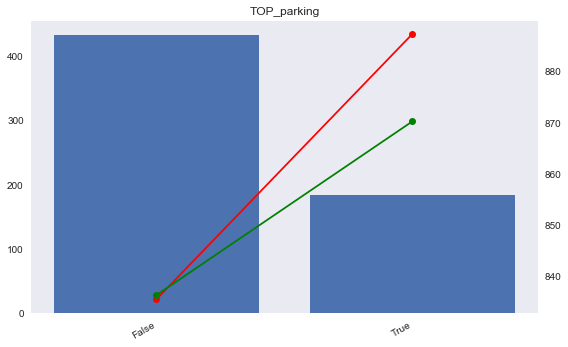

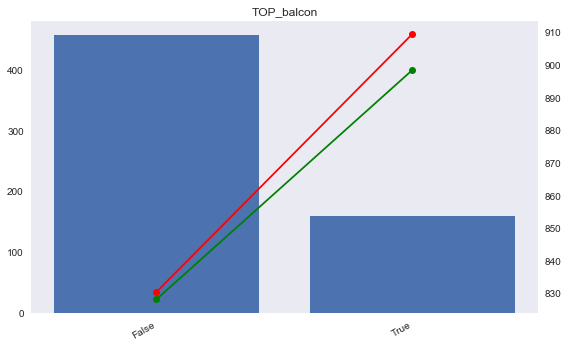

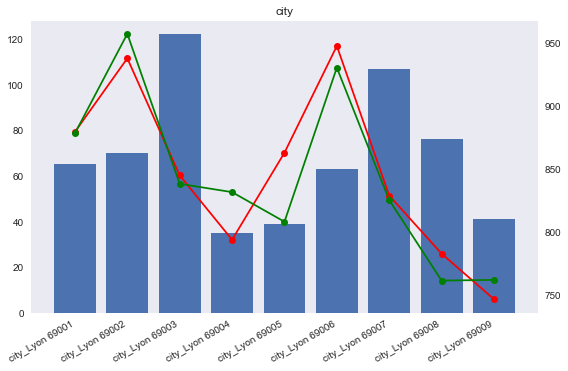

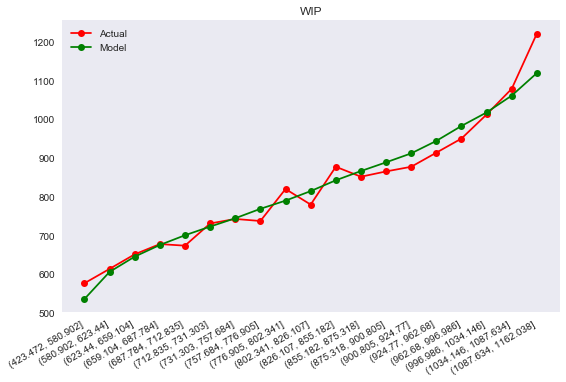

In [24]:
pred_test = pipe.predict(X_test)

df_KPI['LML_base']=[np.sqrt(metrics.mean_squared_error(y_test,pred_test)),
                    metrics.mean_absolute_error(y_test,pred_test),
                    kpis.Gini(y_test,pred_test)
                   ]

for i, var in enumerate(['nb_rooms', 'surface', 'charges', 'furnished', 'TOP_parking', 'TOP_balcon', 'city']):
    graphics.plot_means_match(X_test_,var,y_test,pred_test)
graphics.lift_curve(y_test,pred_test)

In [25]:
df_KPI

,GBM_base,LML_base
RMSE,154.090662,150.552287
MAE,108.727996,106.441009
Gini,0.801192,0.812549


The linear model is slightly better than the GBM on the testing database, but the results are not so differents

### Words analysis

We have all the descriptions available here, but it is hard to extract relevant feature manually. We are going to use some of NLTK tools to ease the process.

First let's have a look at the most frequent words in the database

In [26]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import string

In [27]:
text_desc = ' '.join(df.description)
text_desc = re.sub('\d{1,2}h|\d{1,2}H|\d','',text_desc)
text_desc = [word.lower() for word in nltk.word_tokenize(text_desc) 
             if word.lower() not in stopwords.words('french') and word not in string.punctuation]

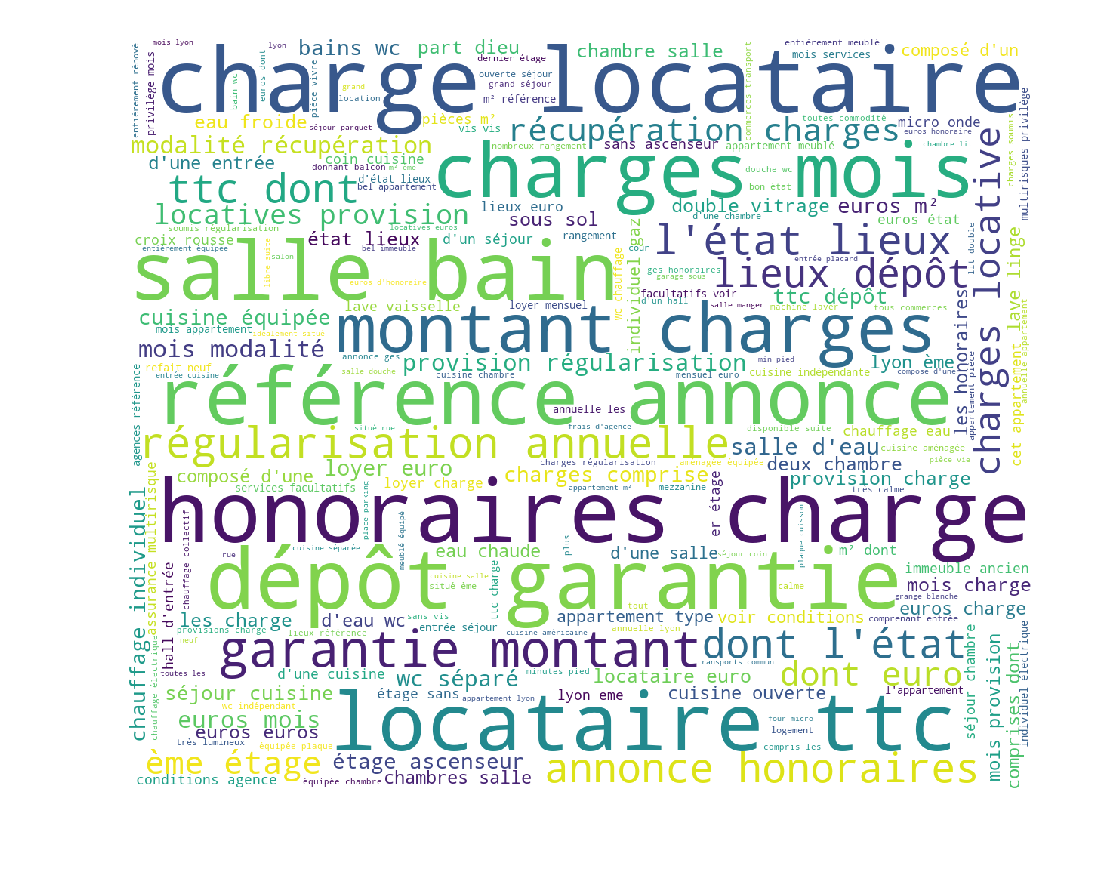

In [28]:
wordcloud = WordCloud(stopwords=stopwords.words("french"),
                          background_color='white',
                          width=1200,
                          height=1000,
                         ).generate(' '.join(text_desc).lower())

plt.figure(figsize=(6, 4),dpi = 250)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Most of the words are part of the adverts, like "charge", "locataire", "ttc" and so on. It does not bring anything to the study, and might be the most frequent.

In [29]:
text_dist=nltk.FreqDist(text_desc)
text_dist.most_common(20)

[('€', 6549),
 ('charges', 3861),
 ('cuisine', 2309),
 ('appartement', 2255),
 ('mois', 2221),
 ('euros', 2157),
 ('salle', 2120),
 ('honoraires', 1885),
 ('locataire', 1864),
 ('charge', 1780),
 ('dont', 1736),
 ('ttc', 1652),
 ('lyon', 1578),
 ('garantie', 1511),
 ('wc', 1484),
 ('séjour', 1459),
 ('dépôt', 1442),
 ('chambre', 1441),
 ('lieux', 1425),
 ('m²', 1397)]

Most of this words are part of the most common, but some might actually be relevant like "cuisine" (kitchen) or "séjour" (living room). We will add useless words to our own stoplist.

In [30]:
mystop = ['€','charges','mois','appartement','euros','honoraires','locataire','charge',
 'dont','ttc','lyon','garantie','dépôt','lieux','référence','annonce','2',"d'une",'loyer',
 'montant','les','chauffage','annuelle','régularisation',"d'un",'m²','1','provision',"l'état",
 'a','locatives','location','modalité','récupération','surface','contact','mail','coordonnées','offre','loca',
         'aide','caf','frais','dagence', 'pouvez','contacter','prov','provision','annonce',
         'voir','absolument','chez','contrat','ope','létat','pierre','delore']

In [31]:
text_desc = [w for w in text_desc if w not in mystop]

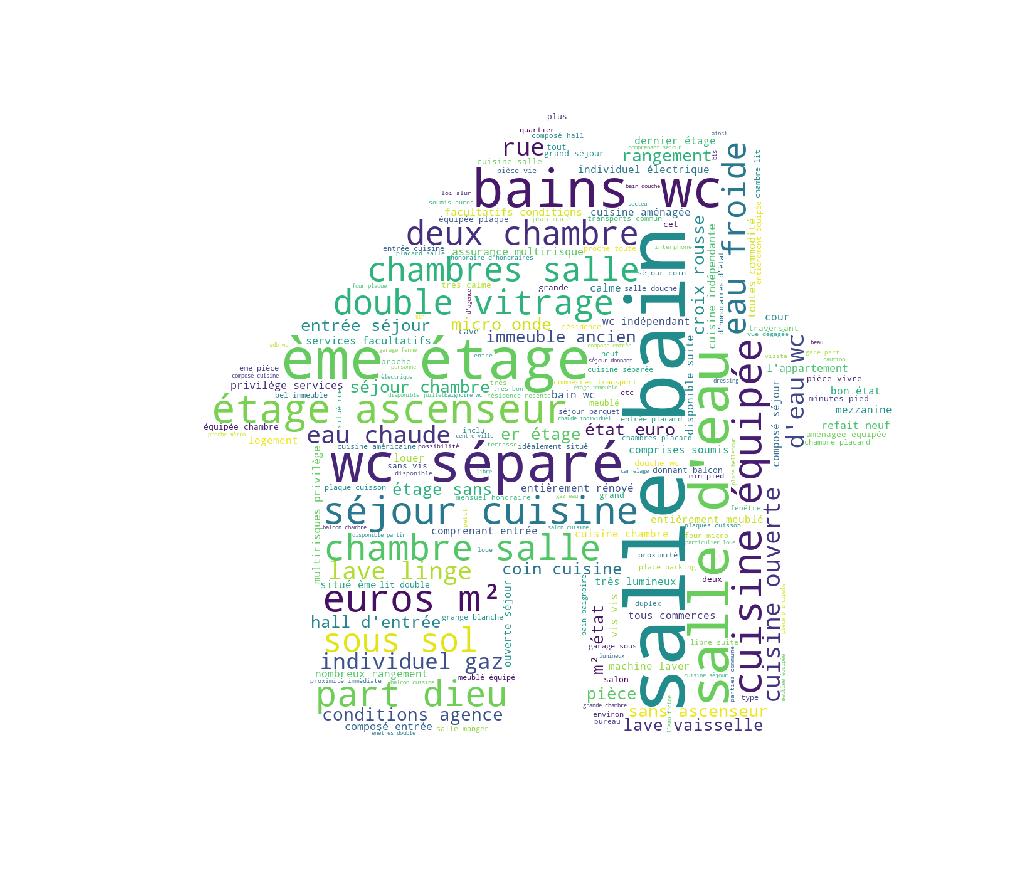

In [32]:
from PIL import Image

wordcloud = WordCloud(stopwords=stopwords.words("french"),
                          background_color='white',
                          width=1200,
                          height=1000,
                          mask = np.array(Image.open("./README_files/house.png"))
                         ).generate(' '.join(text_desc).lower())

plt.figure(figsize=(6, 4),dpi = 250)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

The words now seems to be relevant for what we need. We can now try to use them for our regression.

## Vectorizing the words

First, we need to clean the descriptions in the database.

In [33]:
def word_to_remove(x):
    results = ' '.join(nltk.word_tokenize(x.lower().translate(str.maketrans('','',string.punctuation))))
    results = re.sub('\d{1,2}h|\d{1,2}H|\d',' ',results)
    results = re.sub('\s\s+',' ',results)
    return results.strip()

In [34]:
df['description_alt'] = df["description"].apply(word_to_remove)

In [35]:
var_int =['nb_rooms','surface','charges','furnished','TOP_parking','TOP_balcon','city','description_alt']
X = pd.get_dummies(df[var_int],prefix=["city"],columns=["city"],sparse=True)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    df['price'], 
                                                    random_state=0)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(min_df=5,ngram_range=(1,3),stop_words=stopwords.words("french") + mystop)
vect_train = vectorizer.fit_transform(X_train.description_alt)

Now we create a matrix with all the informations. The vectorized text matrix is quite huge, using a sparsematrix is a good idea as GBM and Lasso regressions support it. But the minmaxscaler doesn't, so we are going to switch for a max abs scaler.

In [37]:
var_used = X_train.drop("description_alt",axis=1).columns.tolist() + [w for w in vectorizer.vocabulary_]
num_feats = X_train.drop("description_alt",axis=1).astype(float).values

from scipy import sparse

training_data = sparse.hstack((num_feats,vect_train))

In [38]:
gbm = GradientBoostingRegressor(random_state = 0,n_estimators=200,learning_rate=0.05)
gbm.fit(training_data, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=0,
             subsample=1.0, verbose=0, warm_start=False)

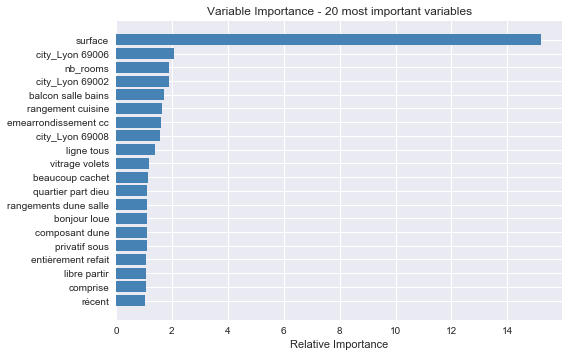

In [39]:
graphics.plot_factor_imp(gbm,20,var_used)

If the surface is still the most important variable, it is interesting to see that the GBM model also uses some variables, like "balcon salle bains" which come from text.

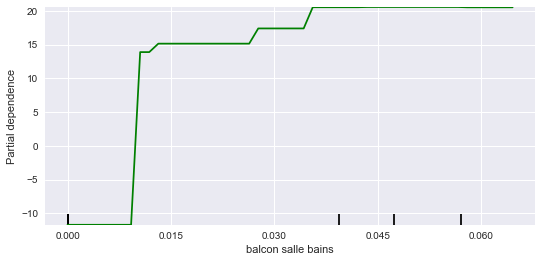

In [40]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
fig, axs = plot_partial_dependence(gbm, training_data.todense(), [var_used.index("balcon salle bains")],
                                       feature_names=var_used,
                                       n_jobs=3, grid_resolution=50)

The presence of a balcony and mentionning "salle bains" (bathroom) seems to increase the cost. 

In [41]:
vect_test = vectorizer.transform(X_test.description_alt)
num_feats = X_test.drop("description_alt",axis=1).astype(float).values
testing_data = sparse.hstack((num_feats,vect_test))

pred_test = gbm.predict(testing_data)

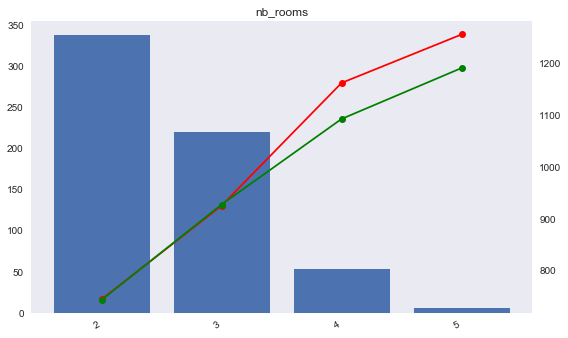

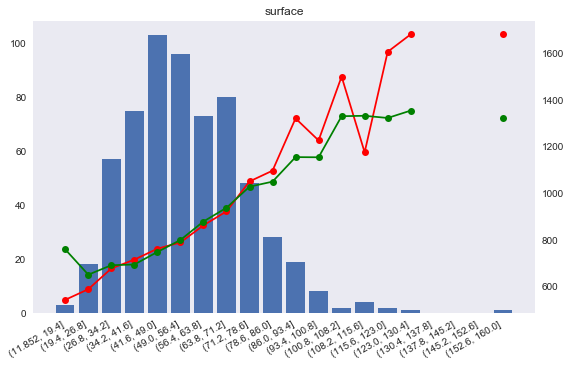

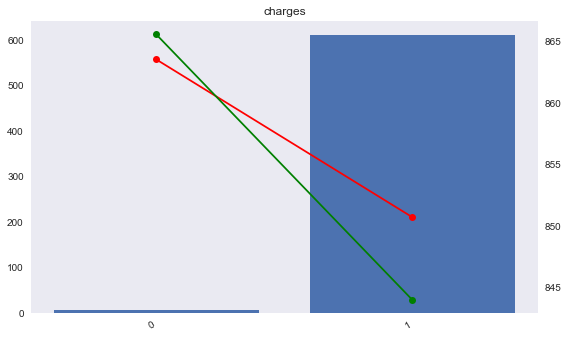

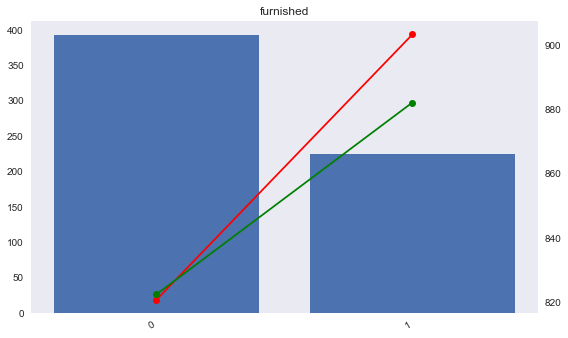

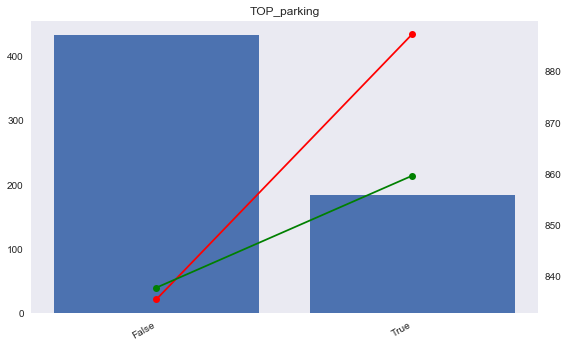

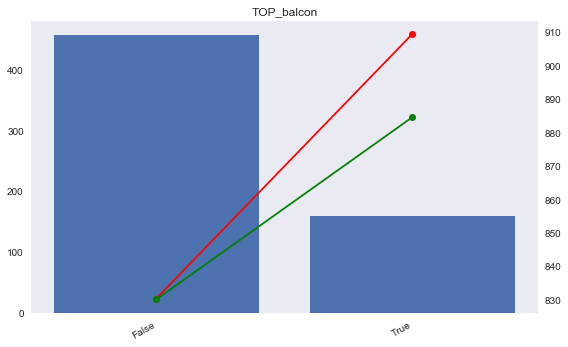

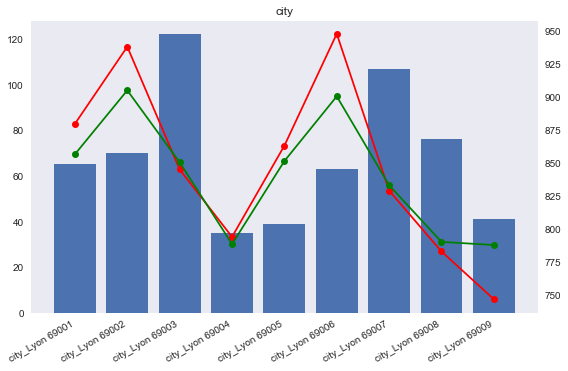

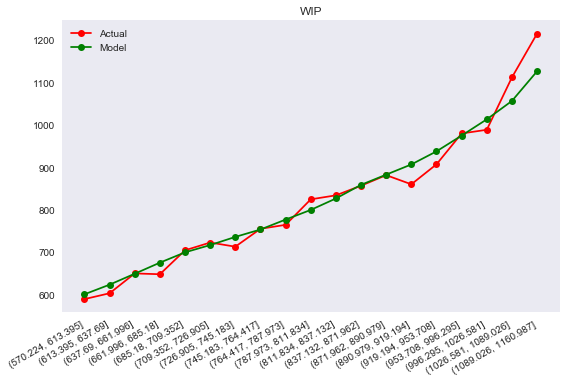

In [42]:
df_KPI['GBM_words']=[np.sqrt(metrics.mean_squared_error(y_test,pred_test)),
                    metrics.mean_absolute_error(y_test,pred_test),
                    kpis.Gini(y_test,pred_test)
                   ]

for i, var in enumerate(['nb_rooms', 'surface', 'charges', 'furnished', 'TOP_parking', 'TOP_balcon', 'city']):
    graphics.plot_means_match(X_test_,var,y_test,pred_test)
graphics.lift_curve(y_test,pred_test)

Now we rebuild our model with lasso regression.

In [43]:
from sklearn.preprocessing import MaxAbsScaler
reg = linear_model.LassoCV(cv=20,alphas=np.logspace(-1,1,5))
mabsscaler =  MaxAbsScaler()
pipe = Pipeline(steps=[('scaling', mabsscaler), ('lassoreg', reg)])
pipe.fit(training_data,y_train)

Pipeline(memory=None,
     steps=[('scaling', MaxAbsScaler(copy=True)), ('lassoreg', LassoCV(alphas=array([  0.1    ,   0.31623,   1.     ,   3.16228,  10.     ]),
    copy_X=True, cv=20, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

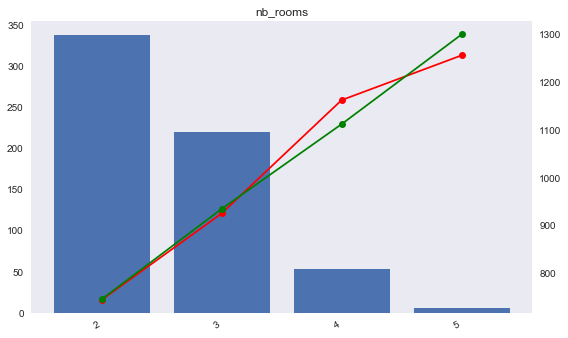

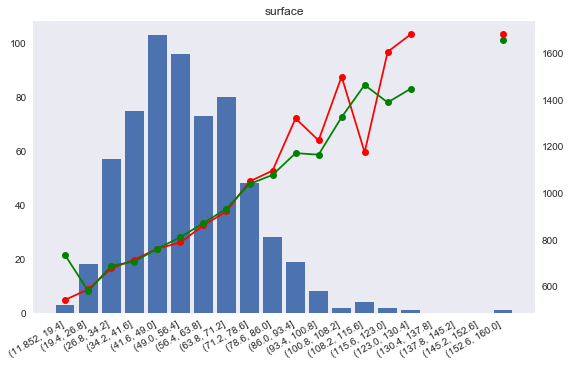

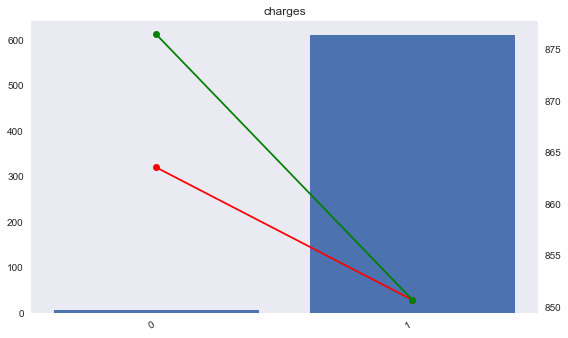

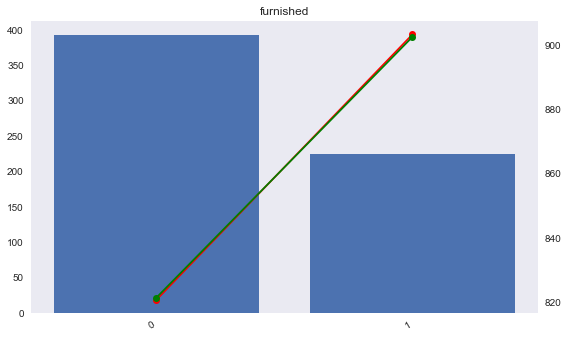

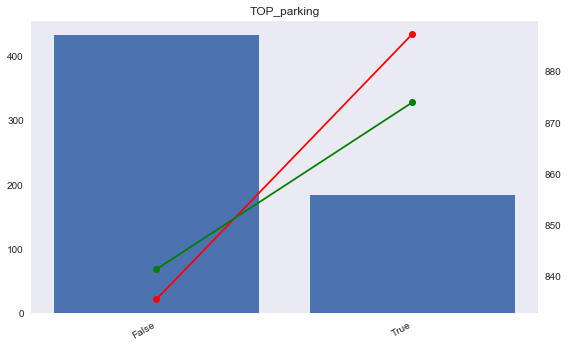

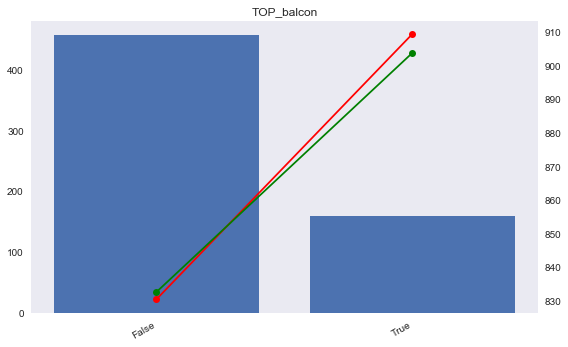

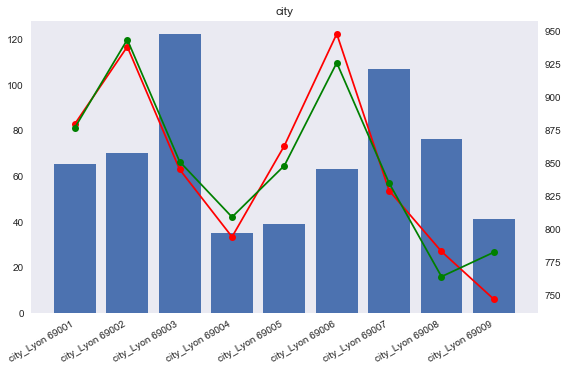

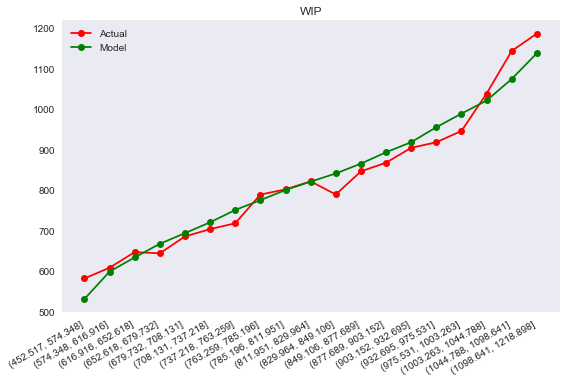

In [44]:
pred_test = pipe.predict(testing_data.todense())

df_KPI['LML_words']=[np.sqrt(metrics.mean_squared_error(y_test,pred_test)),
                    metrics.mean_absolute_error(y_test,pred_test),
                    kpis.Gini(y_test,pred_test)
                   ]

for i, var in enumerate(['nb_rooms', 'surface', 'charges', 'furnished', 'TOP_parking', 'TOP_balcon', 'city']):
    graphics.plot_means_match(X_test_,var,y_test,pred_test)
graphics.lift_curve(y_test,pred_test)

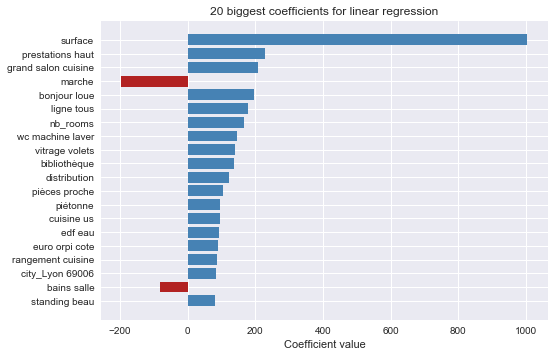

In [45]:
graphics.plot_factor_imp(pipe.named_steps['lassoreg'],20,var_used)

As with the gbm factor importance, we can see here the coefficients values for every variable. The color here gives the impact, whether it is positive or negative.

In [46]:
df_KPI

,GBM_base,LML_base,GBM_words,LML_words
RMSE,154.090662,150.552287,138.517145,137.138232
MAE,108.727996,106.441009,100.038571,99.069579
Gini,0.801192,0.812549,0.839966,0.846074


According to the KPIs, the best model is the lasso regression model that uses the words found on the text.
## Conclusion

By using the datas collected on Leboncoin, we can see useful informations about the real estate market in Lyon. Some are intuitive, like the correlation between price and surface, other are more more surprisingly, like the absence of correlation between price and parking or balcony.

Building a model on that datas can give you intersting insights about the impact of these variables, but it is by using the text of the adverts that we were able to build the best models. 

Such a model can be useful for someone looking for a flat : you can select your criterion and predict the cost of your expected flat, but you will hardly be able to build the text description. On the other hand, you can predict the price of an existing advert, and if the price is higher than prediction, it might be too expensive for what it is.

One must remember that the prices here are provided by both professionals and individuals, so the price does not always reflect the true market value and some might be more expensive due to professionnal expenses.

There are plenty of other things to do with these datas, this study is just a quick one and might be continued or improved in a lot of ways.